In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pandas_datareader import data as pdr

In [2]:
# -----------------------------
# Tickers índice-país
# -----------------------------
tickers = ['EWZ', 'EWJ', 'ERUS', 'INDA', 'FXI', 'SPY']  # Brasil, Japão, Rússia, Índia, China, S&P 500
Brics = ['EWZ', 'FXI', 'ERUS', 'INDA']
Desenvolvidos = ['EWJ', 'SPY']
Variaveis = ['Close', 'Open', 'High', 'Low', 'Volume']

# Intervalo de datas
start_date = '2015-01-01'
end_date = '2019-12-31'

# -----------------------------
# Baixar dados históricos
# -----------------------------
data = yf.download(tickers, start=start_date, end=end_date)

# Transformar MultiIndex em colunas simples
data.columns = [f"{col[0]}_{col[1]}" for col in data.columns]

# Garantir que o índice é datetime
data.index = pd.to_datetime(data.index)

# -----------------------------
# Mapeamento de moedas e tickers FX no Yahoo
# -----------------------------
currency_map = {
    'Close_EWZ': 'BRL',
    'Close_EWJ': 'JPY',
    'Close_ERUS': 'RUB',
    'Close_FXI': 'CNY',
    'Close_INDA': 'INR',
    'Close_SPY': 'USD'
}

fx_map = {
    'BRL': 'USDBRL=X',
    'JPY': 'USDJPY=X',
    'RUB': 'USDRUB=X',
    'CNY': 'USDCNY=X',
    'INR': 'USDINR=X'
}

# -----------------------------
# Função para converter para USD
# -----------------------------
def dollarize_prices(prices_df, currency_map, fx_map, start, end):
    prices_usd = prices_df.copy()
    for col in prices_df.columns:
        cur = currency_map.get(col, 'USD')
        if cur != 'USD':
            fx_ticker = fx_map.get(cur)
            if not fx_ticker:
                print(f"[AVISO] Sem mapeamento FX para {cur}, coluna {col}")
                continue
            
            fx_data = yf.download(fx_ticker, start=start, end=end)
            if 'Adj Close' not in fx_data.columns or fx_data.empty:
                print(f"[AVISO] Sem dados FX para {fx_ticker}, coluna {col}")
                continue
            
            fx = fx_data['Adj Close'].resample('M').last()

            # Se for USD/local, inverte para local/USD
            if fx.mean() > 10:
                fx = 1 / fx

            prices_usd[col] = prices_df[col] * fx.reindex(prices_df.index, method='ffill')
    return prices_usd

# -----------------------------
# Função para deflacionar preços
# -----------------------------
def deflate_prices(prices_df, start, end):
    # Baixar CPI do FRED
    cpi = pdr.DataReader('CPIAUCSL', 'fred', start, end)
    cpi = cpi.resample('M').last()
    cpi = cpi / cpi.iloc[0]  # índice base = 1
    return prices_df.div(cpi.reindex(prices_df.index, method='ffill')['CPIAUCSL'], axis=0)

# -----------------------------
# Filtrar apenas fechamento
# -----------------------------
adj_close = data[['Close_ERUS', 'Close_EWZ', 'Close_EWJ', 'Close_FXI', 'Close_INDA', 'Close_SPY']]

# -----------------------------
# Converter para USD
# -----------------------------
adj_close_usd = dollarize_prices(adj_close, currency_map, fx_map, start_date, end_date)

# -----------------------------
# Deflacionar pelo CPI dos EUA
# -----------------------------
adj_close_real_usd = deflate_prices(adj_close_usd, start_date, end_date)

# -----------------------------
# Calcular retornos diários
# -----------------------------
Return_percent_day = adj_close_real_usd.pct_change().dropna()

mean_return = Return_percent_day.mean()
std_dev = Return_percent_day.std()
coef_var = std_dev / mean_return

# -----------------------------
# Mostrar resultados
# -----------------------------
display(adj_close_real_usd)
display(Return_percent_day)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed


[AVISO] Sem dados FX para USDRUB=X, coluna Close_ERUS


[*********************100%***********************]  1 of 1 completed


[AVISO] Sem dados FX para USDBRL=X, coluna Close_EWZ


[*********************100%***********************]  1 of 1 completed


[AVISO] Sem dados FX para USDJPY=X, coluna Close_EWJ


[*********************100%***********************]  1 of 1 completed


[AVISO] Sem dados FX para USDCNY=X, coluna Close_FXI


[*********************100%***********************]  1 of 1 completed


[AVISO] Sem dados FX para USDINR=X, coluna Close_INDA


C:\Users\Lucas Miranda\AppData\Local\Temp\ipykernel_9176\3060324503.py:77: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cpi = cpi.resample('M').last()


,Close_ERUS,Close_EWZ,Close_EWJ,Close_FXI,Close_INDA,Close_SPY
Date,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2019-12-23,21.135255,29.000832,49.434656,34.543425,29.850865,269.487262
2019-12-24,21.255712,28.975988,49.236154,34.607624,29.741124,269.495596
2019-12-26,21.300886,29.615623,49.368488,34.952740,29.597608,270.930217


,Close_ERUS,Close_EWZ,Close_EWJ,Close_FXI,Close_INDA,Close_SPY
Date,,,,,,
2015-02-03,0.052632,0.028234,-0.001723,0.020267,-0.001526,0.014461
2015-02-04,-0.043333,-0.013169,0.005177,0.008413,-0.009780,-0.003808
2015-02-05,0.052265,0.007950,0.008584,-0.003245,0.001852,0.010095
2015-02-06,0.036424,-0.030423,-0.008511,-0.022553,-0.008626,-0.002765
2015-02-09,-0.000799,0.012784,-0.009442,-0.002379,-0.014606,-0.004476
...,...,...,...,...,...,...
2019-12-23,0.004293,0.009730,-0.000836,-0.000928,-0.002539,0.001528
2019-12-24,0.005699,-0.000857,-0.004015,0.001859,-0.003676,0.000031
2019-12-26,0.002125,0.022075,0.002688,0.009972,-0.004825,0.005323


In [3]:
# Função para calcular NGR (Nível de Globalização Restrita)
def ngr_from_corr(corr_mat):
    vals = []
    for i in range(len(corr_mat)):
        for j in range(i+1, len(corr_mat)):
            vals.append(corr_mat.iloc[i, j])
    vals = np.array(vals)
    d = np.sqrt(np.mean((vals - 1)**2))
    ngr = 1 - d
    return ngr

# Função para calcular carteira de mínima variância
from scipy.optimize import minimize

def min_var_portfolio(cov_matrix):
    n = len(cov_matrix)
    init_w = np.repeat(1/n, n)
    bounds = [(0, 1)] * n
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    res = minimize(lambda w: w @ cov_matrix @ w, init_w, bounds=bounds, constraints=cons)
    return res.x

# Exemplo de cálculo do NGR usando retornos percentuais de fechamento
returns_monthly = adj_close_real_usd.resample('M').last().pct_change().dropna()
corr_matrix_monthly = returns_monthly.corr()
ngr_value = ngr_from_corr(corr_matrix_monthly)
print(f"NGR (mensal) = {ngr_value:.4f}")

# Exemplo de carteira mínima variância
cov_matrix_monthly = returns_monthly.cov()
weights_min_var = min_var_portfolio(cov_matrix_monthly)
print("Pesos da carteira mínima variância:")
print(dict(zip(cov_matrix_monthly.columns, np.round(weights_min_var, 4))))

NGR (mensal) = 0.3951
Pesos da carteira mínima variância:
{'Close_ERUS': np.float64(0.1301), 'Close_EWZ': np.float64(0.0), 'Close_EWJ': np.float64(0.288), 'Close_FXI': np.float64(0.0), 'Close_INDA': np.float64(0.2891), 'Close_SPY': np.float64(0.2929)}


C:\Users\Lucas Miranda\AppData\Local\Temp\ipykernel_9176\1068409837.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_monthly = adj_close_real_usd.resample('M').last().pct_change().dropna()


,Close_ERUS,Close_EWZ,Close_EWJ,Close_FXI,Close_INDA,Close_SPY
Date,,,,,,
2015-02-03,0.052632,0.028234,-0.001723,0.020267,-0.001526,0.014461
2015-02-04,-0.043333,-0.013169,0.005177,0.008413,-0.009780,-0.003808
2015-02-05,0.052265,0.007950,0.008584,-0.003245,0.001852,0.010095
2015-02-06,0.036424,-0.030423,-0.008511,-0.022553,-0.008626,-0.002765
2015-02-09,-0.000799,0.012784,-0.009442,-0.002379,-0.014606,-0.004476
...,...,...,...,...,...,...
2019-12-23,0.004293,0.009730,-0.000836,-0.000928,-0.002539,0.001528
2019-12-24,0.005699,-0.000857,-0.004015,0.001859,-0.003676,0.000031
2019-12-26,0.002125,0.022075,0.002688,0.009972,-0.004825,0.005323


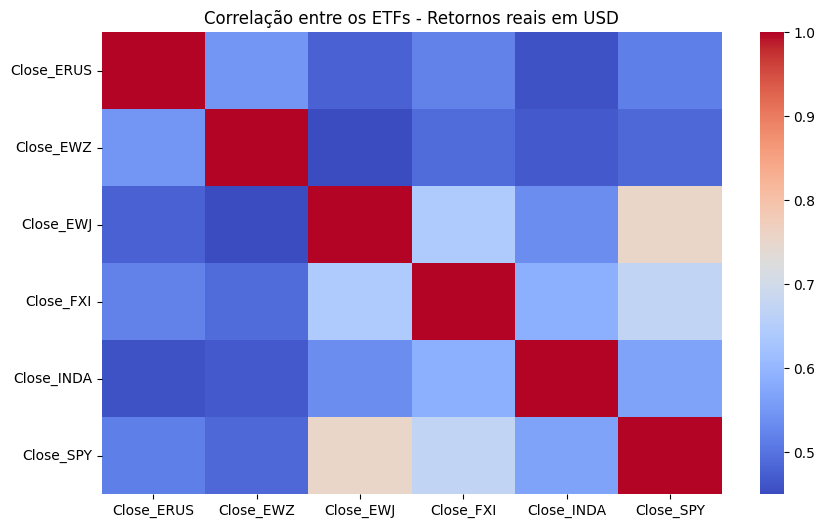

In [4]:
#Todas variaves - Heatmap
display(Return_percent_day)

plt.figure(figsize=(10, 6))
sns.heatmap(Return_percent_day.corr(), cmap='coolwarm')
plt.title('Correlação entre os ETFs - Retornos reais em USD')
plt.show()

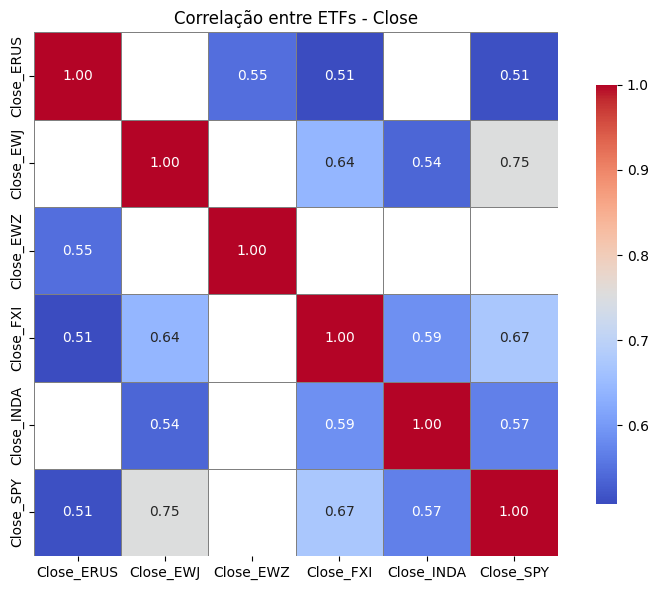

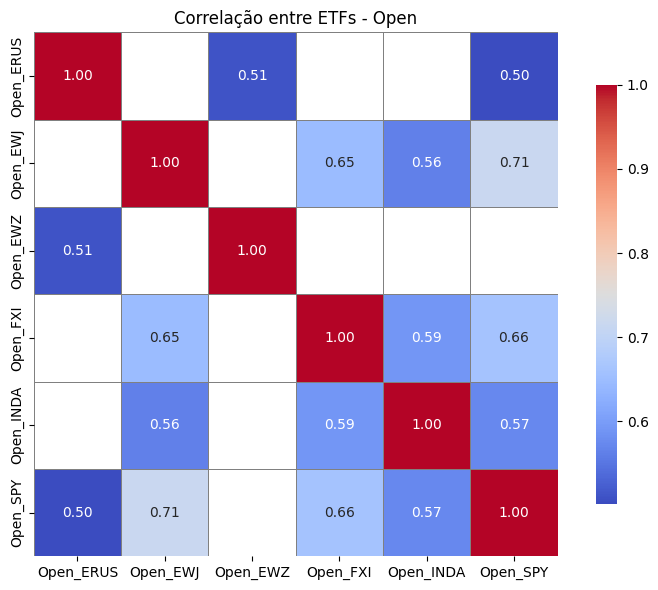

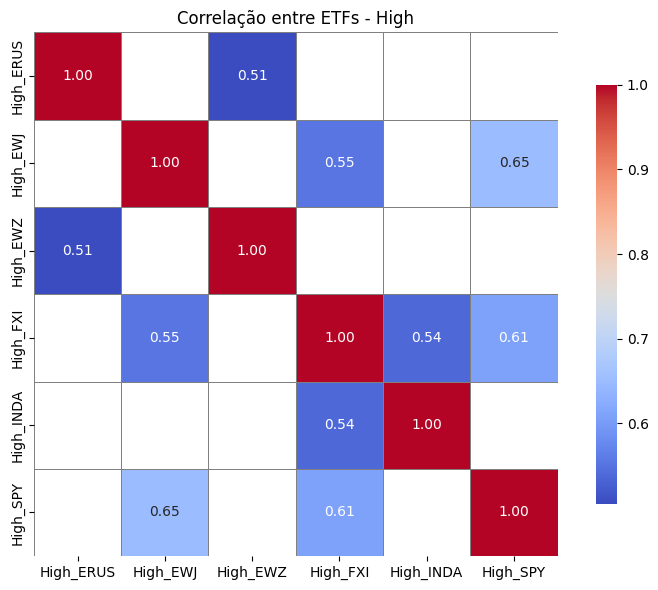

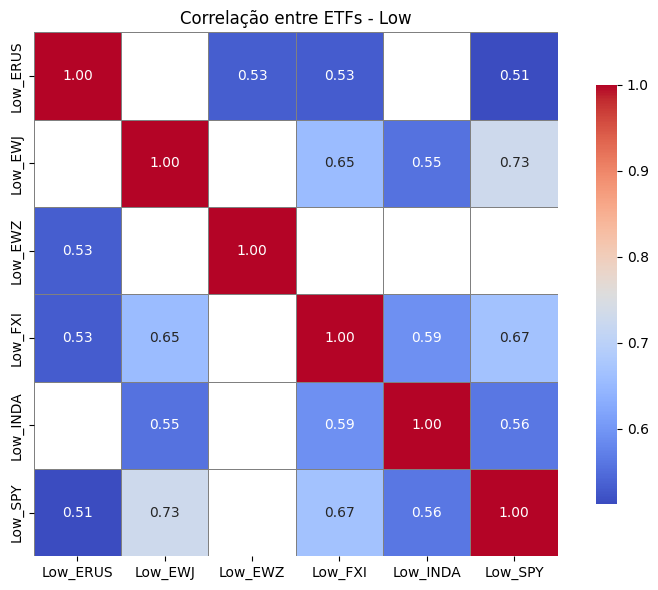

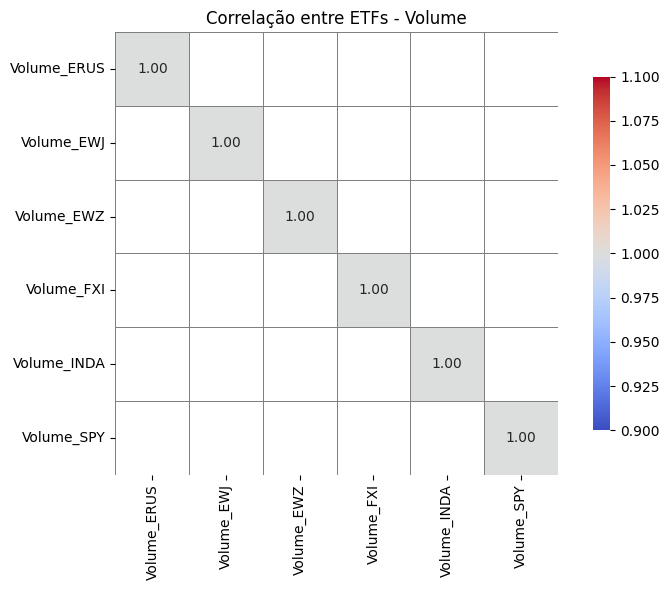

In [5]:
for tipo in Variaveis:
    subset = data.filter(like=tipo)
    returns = subset.pct_change().dropna()
    corr_matrix = returns.corr()
    mask = corr_matrix.abs() < 0.5
    plt.figure(figsize=(8, 6))

  
    #sns.heatmap(returns.corr(), annot=True, cmap='coolwarm') # Printa todas as correlações


#Tira correlações abaixo de 0.5
    sns.heatmap(corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={"shrink": 0.8})
    plt.title(f'Correlação entre ETFs - {tipo}')
    plt.tight_layout()
    plt.show()

,Close_ERUS,Close_EWZ,Close_EWJ,Close_FXI,Close_INDA,Close_SPY
Date,,,,,,
2015-01-02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2015-01-05,95.986041,96.578043,98.845467,99.640055,98.387626,98.194031
2015-01-06,95.811541,98.303147,97.246894,98.416474,95.393224,97.269164
2015-01-07,99.563718,100.961556,98.667841,101.007622,97.268842,98.481219
2015-01-08,106.020954,102.573548,99.911192,101.823367,99.868396,100.228791
...,...,...,...,...,...,...
2019-12-23,193.793084,149.660222,143.928491,117.721209,122.502564,172.551120
2019-12-24,194.897570,149.532012,143.350552,117.939997,122.052203,172.556456
2019-12-26,195.311779,152.832883,143.735841,119.116124,121.463241,173.475035


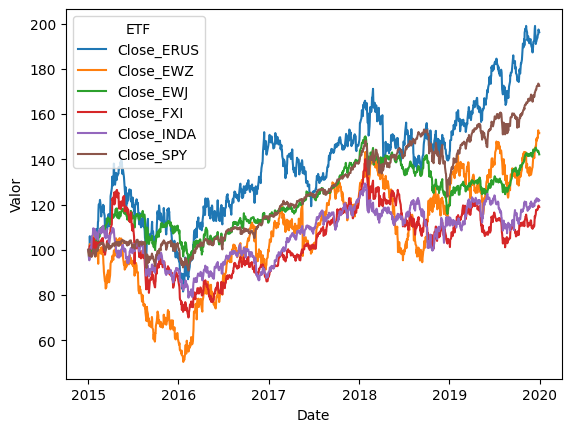

In [6]:
# Reenomeando para facilitação (Acredito que ajudará)
#data.rename(columns=lambda x: x.replace("Adj Close", "AdjClose"), inplace=True)

#Filtrar apenas fechamento
adj_close = data[['Close_ERUS', 'Close_EWZ' , 'Close_EWJ', 'Close_FXI', 'Close_INDA', 'Close_SPY']]

# Normalização para variações percentuais
normalized = adj_close/ adj_close.iloc[0] * 100

#Comparar o desempenho acumulado (matplto)
#normalized.plot(figsize=(12, 6), title='Desempenho acumulado dos ETFs (base 100)')

# Transforma os dados para formato "long" (necessário para seaborn)
normalized_long = normalized.reset_index().melt(id_vars='Date', var_name='ETF', value_name='Valor')

# Cria o gráfico com seaborn
sns.lineplot(data=normalized_long, x='Date', y='Valor', hue='ETF', palette='tab10')


display(normalized)

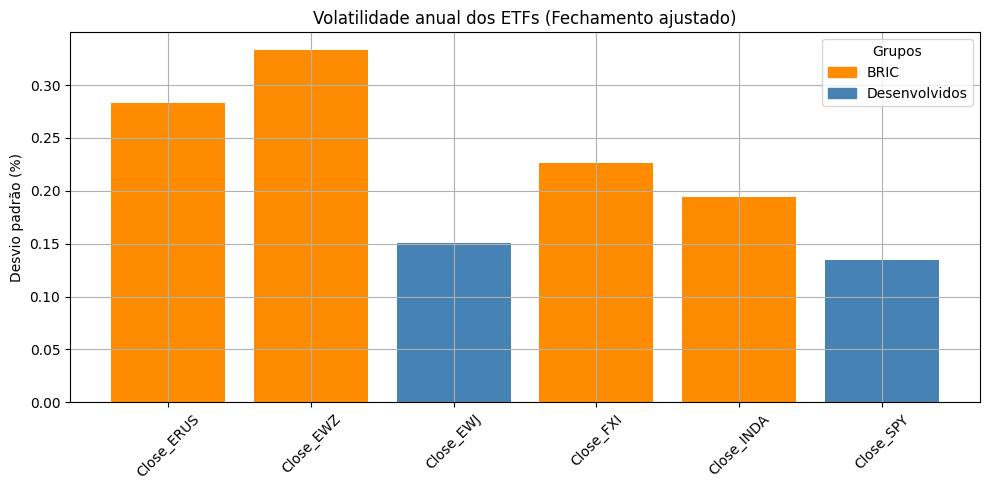

,Volume_ERUS,Volume_EWJ,Volume_EWZ,Volume_FXI,Volume_INDA,Volume_SPY
Date,,,,,,
2015-01-05,0.606790,0.205907,0.249643,0.256589,-0.340923,0.396545
2015-01-06,-0.621700,-0.056223,-0.045333,0.185311,0.884071,0.232967
2015-01-07,-0.107200,0.170991,-0.224899,-0.081265,-0.338789,-0.400689
2015-01-08,2.106166,-0.477983,-0.142840,-0.343447,-0.109808,0.174485
2015-01-09,-0.604660,1.175420,-0.325439,0.259338,-0.039097,0.077093
...,...,...,...,...,...,...
2019-12-23,-0.537724,-0.388492,-0.129727,-0.667067,0.102301,-0.639872
2019-12-24,-0.135800,-0.054542,-0.895835,-0.451597,-0.519512,-0.617475
2019-12-26,-0.483282,-0.046312,5.803085,1.233338,-0.123311,0.524973


Close_ERUS    0.283063
Close_EWZ     0.333143
Close_EWJ     0.150692
Close_FXI     0.226095
Close_INDA    0.193819
Close_SPY     0.134325
dtype: float64

In [7]:
returns_percent_close = adj_close.pct_change().dropna() # retornos percentuais dia - Fechamento

volatility = returns_percent_close.std() * np.sqrt(252)

# Grupos
bric = ['Close_EWZ', 'Close_ERUS', 'Close_FXI', 'Close_INDA']

desenvolvidos = ['Close_SPY', 'Close_EWJ']

# Cores
cores = []
for etf in volatility.index:
    if etf in bric:
        cores.append('darkorange')
    elif etf in desenvolvidos:
        cores.append('steelblue')
    else:
        cores.append('gray')



# Gráfico
plt.figure(figsize=(10, 5))
plt.bar(volatility.index, volatility.values, color=cores)
plt.title('Volatilidade anual dos ETFs (Fechamento ajustado)')
plt.ylabel('Desvio padrão (%)')
plt.grid(True)

# Legenda
legenda = [
    Patch(color='darkorange', label='BRIC'),
    Patch(color='steelblue', label='Desenvolvidos')
]
plt.legend(handles=legenda, title='Grupos')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(returns)
display (volatility) 

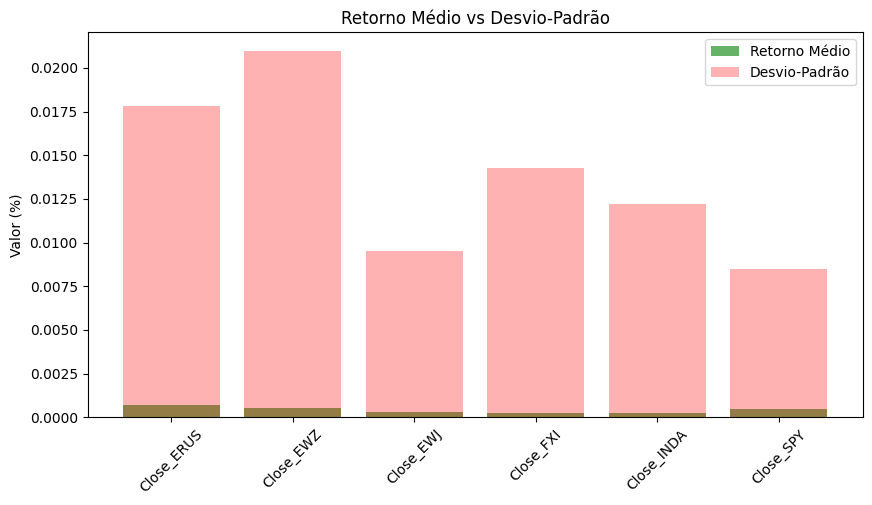

In [8]:
mean_return_close = returns_percent_close.mean()
std_dev_close = returns_percent_close.std()
coef_var_close = std_dev_close / mean_return_close

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(mean_return_close.index, mean_return_close, color='green', alpha=0.6, label='Retorno Médio')
ax.bar(std_dev_close.index, std_dev_close, color='red', alpha=0.3, label='Desvio-Padrão')
ax.set_ylabel('Valor (%)')
ax.set_title('Retorno Médio vs Desvio-Padrão')
ax.legend()
plt.xticks(rotation=45)
plt.show()

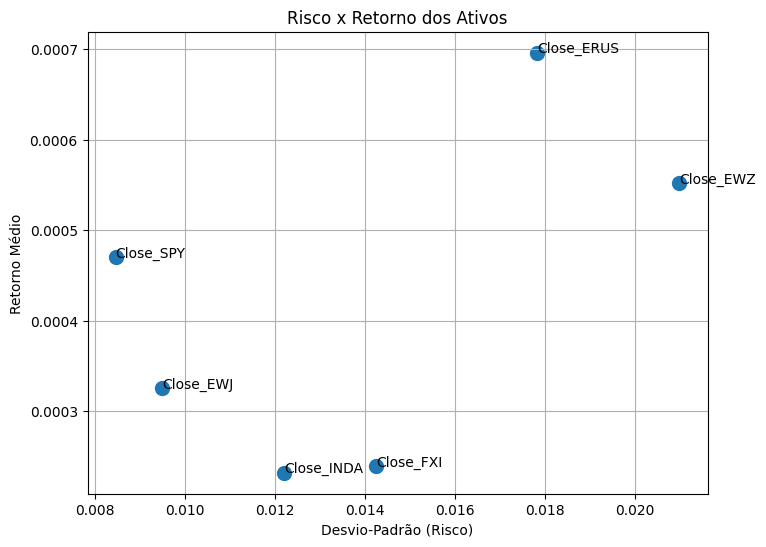

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(std_dev_close, mean_return_close, s=100)

for i in mean_return_close.index:
    plt.annotate(i, (std_dev_close[i], mean_return_close[i]))

plt.xlabel('Desvio-Padrão (Risco)')
plt.ylabel('Retorno Médio')
plt.title('Risco x Retorno dos Ativos')
plt.grid(True)
plt.show()

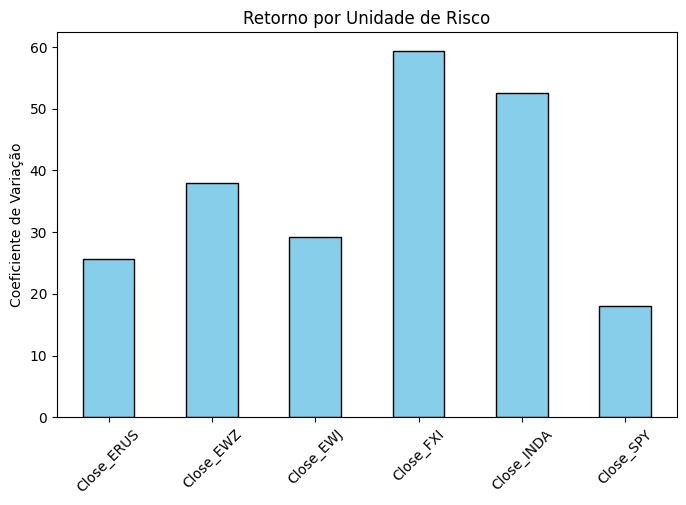

In [12]:
coef_var_close.plot(kind='bar', figsize=(8,5), color='skyblue', edgecolor='black')
plt.ylabel('Coeficiente de Variação')
plt.title('Retorno por Unidade de Risco')
plt.xticks(rotation=45)
plt.show()

Período pandêmico

In [13]:
# Intervalo de datas 
start_date = '2020-01-01'
end_date = '2023-12-31'

# Dados históricos dos tickers
data = yf.download(tickers, start=start_date, end=end_date)

# Transformar MultiIndex em colunas normais
data.columns = [f"{col[0]}_{col[1]}" for col in data.columns]

#Acertando datas 
data.index = pd.to_datetime(data.index)

# Reenomeando para facilitação (Acredito que ajudará)
data.rename(columns=lambda x: x.replace("Adj Close", "AdjClose"), inplace=True)

#display(data)

[*********************100%***********************]  6 of 6 completed


In [14]:
# -----------------------------
# Filtrar apenas fechamento
# -----------------------------
adj_close = data[['Close_ERUS', 'Close_EWZ', 'Close_EWJ', 'Close_FXI', 'Close_INDA', 'Close_SPY']]

# -----------------------------
# Converter para USD
# -----------------------------
adj_close_usd = dollarize_prices(adj_close, currency_map, fx_map, start_date, end_date)

# -----------------------------
# Deflacionar pelo CPI dos EUA
# -----------------------------
adj_close_real_usd = deflate_prices(adj_close_usd, start_date, end_date)

# -----------------------------
# Calcular retornos diários
# -----------------------------
Return_percent_day = adj_close_real_usd.pct_change().dropna()

mean_return = Return_percent_day.mean()
std_dev = Return_percent_day.std()
coef_var = std_dev / mean_return

# -----------------------------
# Mostrar resultados
# -----------------------------
display(adj_close_real_usd)
display(Return_percent_day)

[*********************100%***********************]  1 of 1 completed


[AVISO] Sem dados FX para USDRUB=X, coluna Close_ERUS


[*********************100%***********************]  1 of 1 completed


[AVISO] Sem dados FX para USDBRL=X, coluna Close_EWZ


[*********************100%***********************]  1 of 1 completed


[AVISO] Sem dados FX para USDJPY=X, coluna Close_EWJ


[*********************100%***********************]  1 of 1 completed


[AVISO] Sem dados FX para USDCNY=X, coluna Close_FXI


[*********************100%***********************]  1 of 1 completed

[AVISO] Sem dados FX para USDINR=X, coluna Close_INDA



C:\Users\Lucas Miranda\AppData\Local\Temp\ipykernel_9176\3060324503.py:77: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cpi = cpi.resample('M').last()


,Close_ERUS,Close_EWZ,Close_EWJ,Close_FXI,Close_INDA,Close_SPY
Date,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-12-22,3.935261,26.448796,51.643564,18.775515,40.382661,390.998367
2023-12-26,3.935261,26.853708,51.627255,18.913988,40.524617,392.649348
2023-12-27,3.935261,26.945385,51.912668,18.938427,40.783480,393.359295


,Close_ERUS,Close_EWZ,Close_EWJ,Close_FXI,Close_INDA,Close_SPY
Date,,,,,,
2020-02-03,0.001203,0.015311,0.007619,0.009814,-0.013047,0.007429
2020-02-04,0.015618,0.006527,0.015123,0.026912,0.024383,0.015241
2020-02-05,0.014668,0.006038,0.008972,0.003397,0.008317,0.011548
2020-02-06,-0.016088,-0.018226,0.007550,0.006772,0.007679,0.003365
2020-02-07,-0.020142,-0.017885,-0.009659,-0.008888,-0.010725,-0.005330
...,...,...,...,...,...,...
2023-12-22,0.000000,0.008447,0.003168,-0.027836,0.004153,0.002010
2023-12-26,0.000000,0.015309,-0.000316,0.007375,0.003515,0.004222
2023-12-27,0.000000,0.003414,0.005528,0.001292,0.006388,0.001808


In [15]:
# Exemplo de cálculo do NGR usando retornos percentuais de fechamento
returns_monthly = adj_close_real_usd.resample('M').last().pct_change().dropna()
corr_matrix_monthly = returns_monthly.corr()
ngr_value = ngr_from_corr(corr_matrix_monthly)
print(f"NGR (mensal) = {ngr_value:.4f}")

# Exemplo de carteira mínima variância
cov_matrix_monthly = returns_monthly.cov()
weights_min_var = min_var_portfolio(cov_matrix_monthly)
print("Pesos da carteira mínima variância:")
print(dict(zip(cov_matrix_monthly.columns, np.round(weights_min_var, 4))))

NGR (mensal) = 0.3934
Pesos da carteira mínima variância:
{'Close_ERUS': np.float64(0.0), 'Close_EWZ': np.float64(0.0), 'Close_EWJ': np.float64(0.3806), 'Close_FXI': np.float64(0.1388), 'Close_INDA': np.float64(0.2248), 'Close_SPY': np.float64(0.2558)}


C:\Users\Lucas Miranda\AppData\Local\Temp\ipykernel_9176\3894232610.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_monthly = adj_close_real_usd.resample('M').last().pct_change().dropna()


,Close_ERUS,Close_EWZ,Close_EWJ,Close_FXI,Close_INDA,Close_SPY
Date,,,,,,
2020-02-03,0.001203,0.015311,0.007619,0.009814,-0.013047,0.007429
2020-02-04,0.015618,0.006527,0.015123,0.026912,0.024383,0.015241
2020-02-05,0.014668,0.006038,0.008972,0.003397,0.008317,0.011548
2020-02-06,-0.016088,-0.018226,0.007550,0.006772,0.007679,0.003365
2020-02-07,-0.020142,-0.017885,-0.009659,-0.008888,-0.010725,-0.005330
...,...,...,...,...,...,...
2023-12-22,0.000000,0.008447,0.003168,-0.027836,0.004153,0.002010
2023-12-26,0.000000,0.015309,-0.000316,0.007375,0.003515,0.004222
2023-12-27,0.000000,0.003414,0.005528,0.001292,0.006388,0.001808


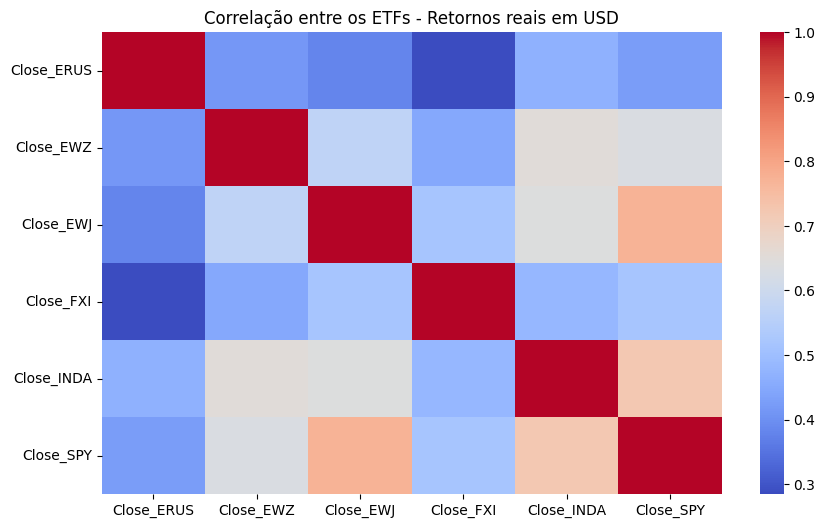

In [16]:
#Todas variaves - Heatmap
display(Return_percent_day)

plt.figure(figsize=(10, 6))
sns.heatmap(Return_percent_day.corr(), cmap='coolwarm')
plt.title('Correlação entre os ETFs - Retornos reais em USD')
plt.show()

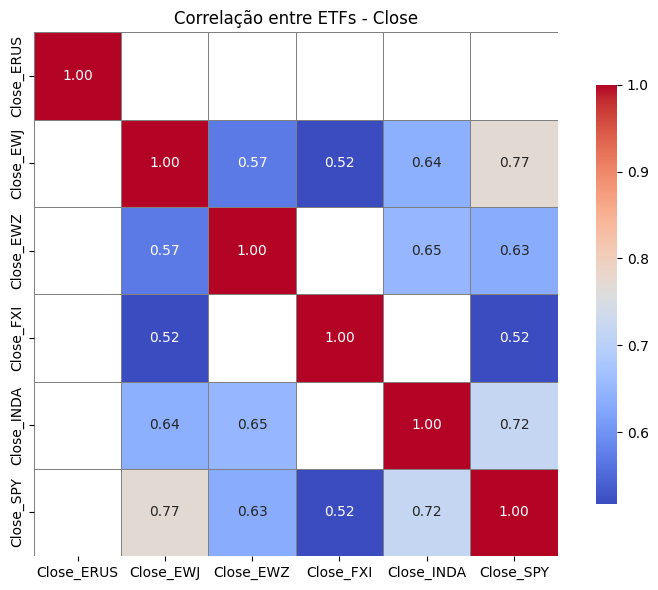

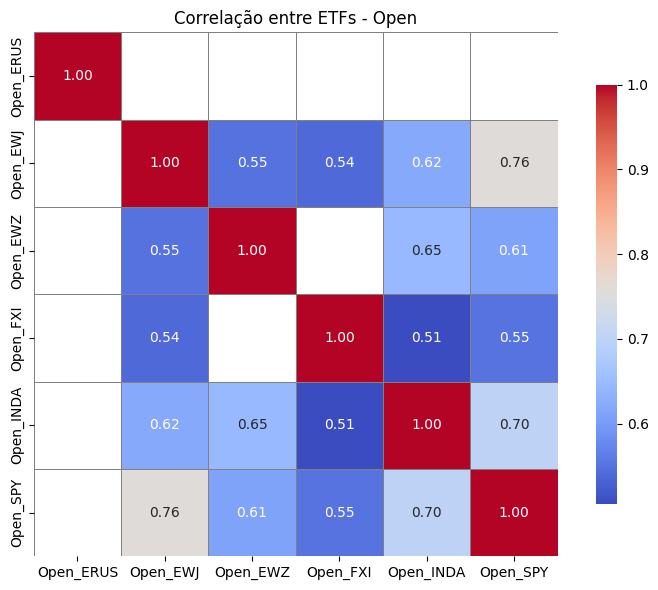

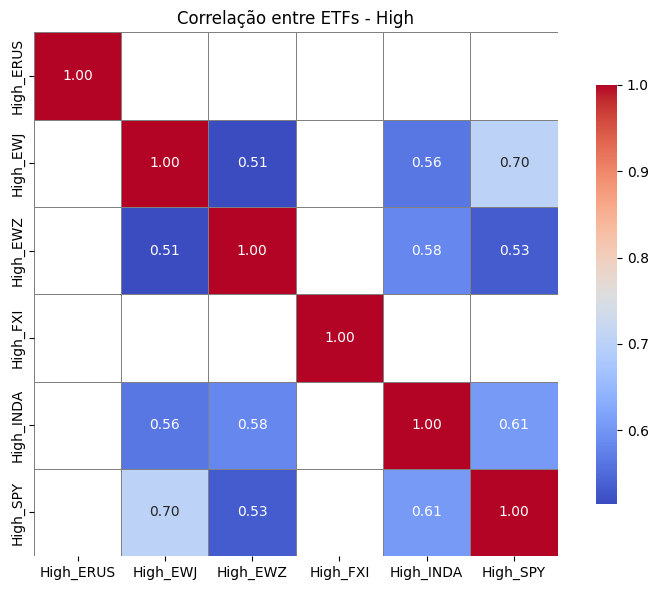

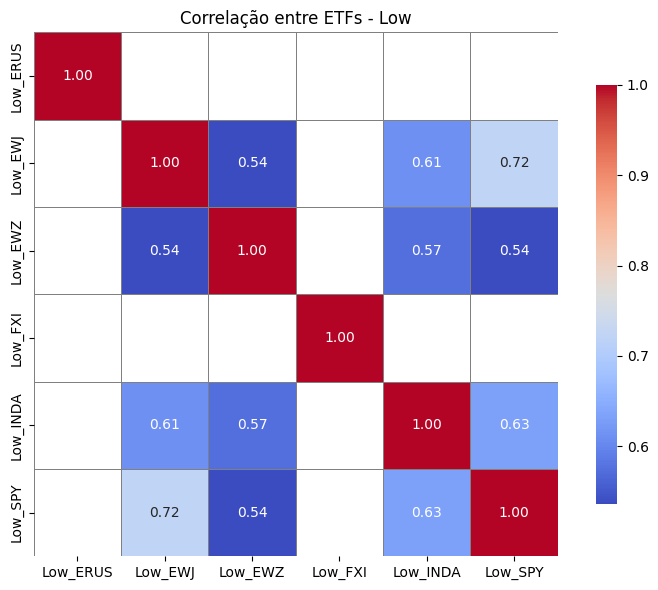

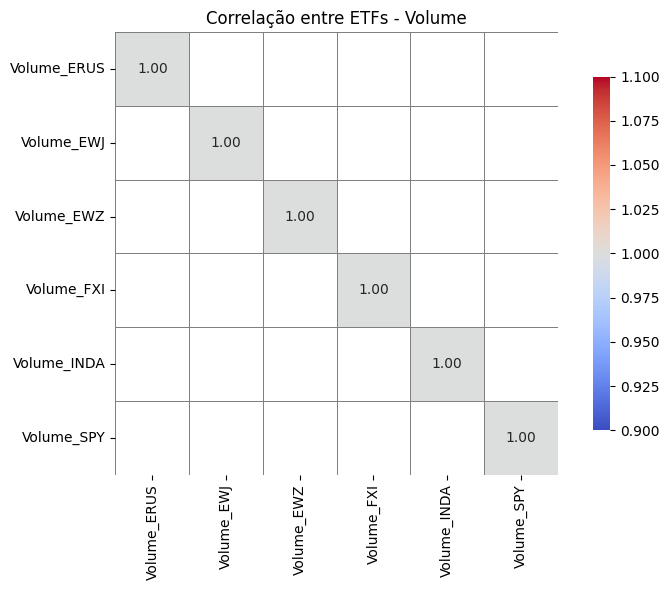

In [17]:
for tipo in Variaveis:
    subset = data.filter(like=tipo)
    returns = subset.pct_change().dropna()
    corr_matrix = returns.corr()
    mask = corr_matrix.abs() < 0.5
    plt.figure(figsize=(8, 6))

  
    #sns.heatmap(returns.corr(), annot=True, cmap='coolwarm') # Printa todas as correlações


#Tira correlações abaixo de 0.5
    sns.heatmap(corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={"shrink": 0.8})
    plt.title(f'Correlação entre ETFs - {tipo}')
    plt.tight_layout()
    plt.show()

,Close_ERUS,Close_EWZ,Close_EWJ,Close_FXI,Close_INDA,Close_SPY
Date,,,,,,
2020-01-02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2020-01-03,97.880102,99.132416,98.897423,97.838683,98.313662,99.242754
2020-01-06,99.338958,97.603804,99.248251,98.306603,97.161324,99.621372
2020-01-07,99.042632,97.541834,99.415308,98.061504,97.020801,99.341226
2020-01-08,100.866197,97.108019,99.432001,97.994657,98.313662,99.870696
...,...,...,...,...,...,...
2023-12-22,19.343204,95.023438,112.895346,56.414500,145.508744,155.265310
2023-12-26,19.343204,96.478178,112.859694,56.830568,146.020247,155.920914
2023-12-27,19.343204,96.807551,113.483622,56.903999,146.952996,156.202833


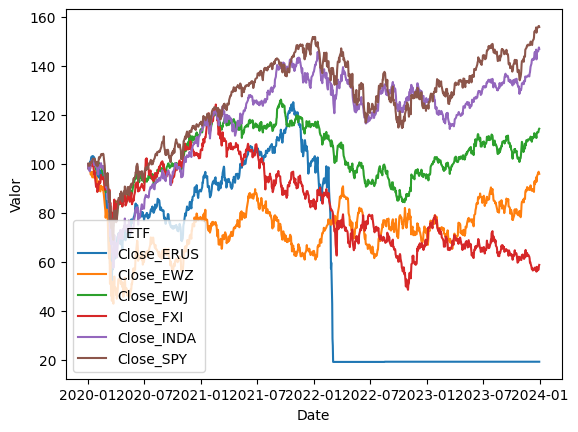

In [18]:
# Reenomeando para facilitação (Acredito que ajudará)
#data.rename(columns=lambda x: x.replace("Adj Close", "AdjClose"), inplace=True)

#Filtrar apenas fechamento
adj_close = data[['Close_ERUS', 'Close_EWZ' , 'Close_EWJ', 'Close_FXI', 'Close_INDA', 'Close_SPY']]

# Normalização para variações percentuais
normalized = adj_close/ adj_close.iloc[0] * 100

#Comparar o desempenho acumulado (matplto)
#normalized.plot(figsize=(12, 6), title='Desempenho acumulado dos ETFs (base 100)')

# Transforma os dados para formato "long" (necessário para seaborn)
normalized_long = normalized.reset_index().melt(id_vars='Date', var_name='ETF', value_name='Valor')

# Cria o gráfico com seaborn
sns.lineplot(data=normalized_long, x='Date', y='Valor', hue='ETF', palette='tab10')


display(normalized)

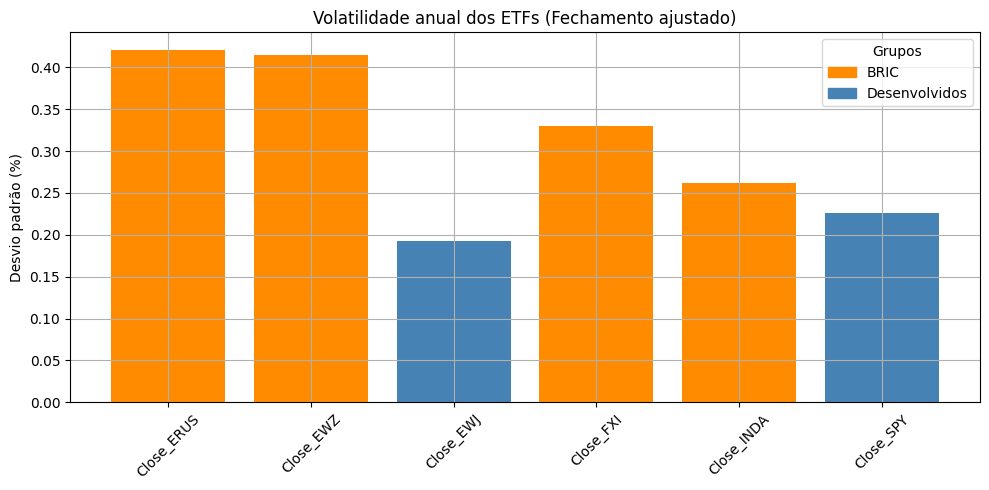

,Volume_ERUS,Volume_EWJ,Volume_EWZ,Volume_FXI,Volume_INDA,Volume_SPY
Date,,,,,,
2020-01-03,-0.227055,-0.330976,-0.206429,-0.180136,0.052699,0.313747
2020-01-06,-0.353954,-0.358392,0.126730,-0.394365,0.105532,-0.283823
2020-01-07,-0.483706,-0.068762,-0.419138,0.270096,-0.348952,-0.272353
2020-01-08,0.922389,0.539253,0.181483,0.715221,1.055336,0.686471
2020-01-09,-0.552134,-0.078254,0.069178,-0.129920,-0.131290,-0.290247
...,...,...,...,...,...,...
2022-02-28,0.480389,-0.325673,-0.165625,0.151873,-0.431103,0.195481
2022-03-01,-0.001573,0.132114,0.741393,-0.100974,0.510755,-0.053766
2022-03-02,-0.169313,-0.371763,0.068812,-0.152965,-0.202386,-0.145584


Close_ERUS    0.420768
Close_EWZ     0.414645
Close_EWJ     0.193047
Close_FXI     0.329456
Close_INDA    0.262130
Close_SPY     0.226271
dtype: float64

In [19]:
returns_percent_close = adj_close.pct_change().dropna() # retornos percentuais dia - Fechamento

volatility = returns_percent_close.std() * np.sqrt(252)

# Grupos
bric = ['Close_EWZ', 'Close_ERUS', 'Close_FXI', 'Close_INDA']

desenvolvidos = ['Close_SPY', 'Close_EWJ']

# Cores
cores = []
for etf in volatility.index:
    if etf in bric:
        cores.append('darkorange')
    elif etf in desenvolvidos:
        cores.append('steelblue')
    else:
        cores.append('gray')



# Gráfico
plt.figure(figsize=(10, 5))
plt.bar(volatility.index, volatility.values, color=cores)
plt.title('Volatilidade anual dos ETFs (Fechamento ajustado)')
plt.ylabel('Desvio padrão (%)')
plt.grid(True)

# Legenda
legenda = [
    Patch(color='darkorange', label='BRIC'),
    Patch(color='steelblue', label='Desenvolvidos')
]
plt.legend(handles=legenda, title='Grupos')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(returns)
display (volatility) 

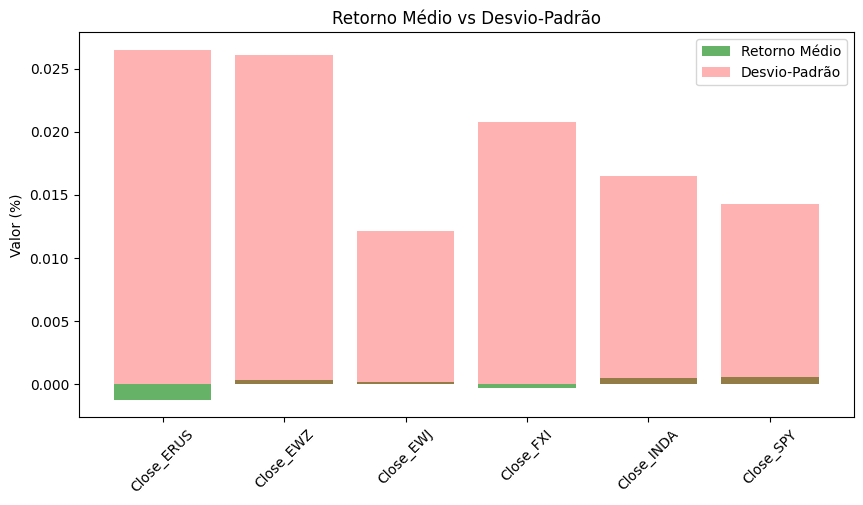

In [20]:
mean_return_close = returns_percent_close.mean()
std_dev_close = returns_percent_close.std()
coef_var_close = std_dev_close / mean_return_close

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(mean_return_close.index, mean_return_close, color='green', alpha=0.6, label='Retorno Médio')
ax.bar(std_dev_close.index, std_dev_close, color='red', alpha=0.3, label='Desvio-Padrão')
ax.set_ylabel('Valor (%)')
ax.set_title('Retorno Médio vs Desvio-Padrão')
ax.legend()
plt.xticks(rotation=45)
plt.show()

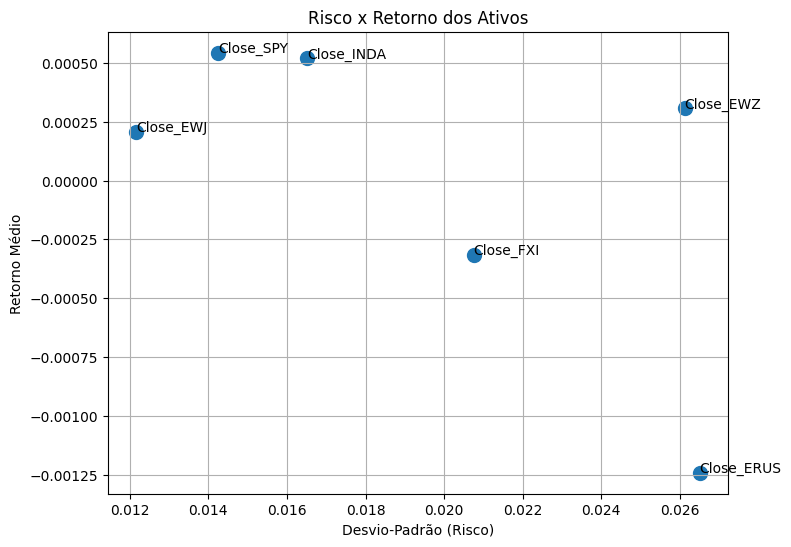

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(std_dev_close, mean_return_close, s=100)

for i in mean_return_close.index:
    plt.annotate(i, (std_dev_close[i], mean_return_close[i]))

plt.xlabel('Desvio-Padrão (Risco)')
plt.ylabel('Retorno Médio')
plt.title('Risco x Retorno dos Ativos')
plt.grid(True)
plt.show()

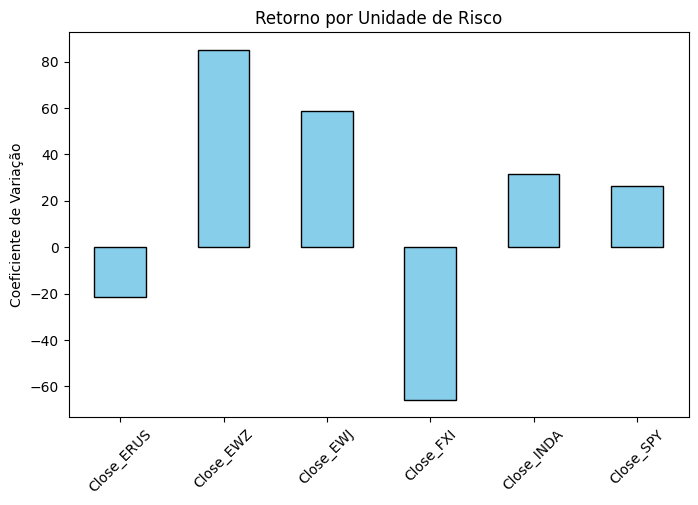

In [22]:
coef_var_close.plot(kind='bar', figsize=(8,5), color='skyblue', edgecolor='black')
plt.ylabel('Coeficiente de Variação')
plt.title('Retorno por Unidade de Risco')
plt.xticks(rotation=45)
plt.show()